# Setup (same everywhere)

## Mount Drive


In [ ]:
from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%cd drive/'My Drive'/repositories/moleculenet/notebooks

[Errno 2] No such file or directory: 'drive/My Drive/repositories/moleculenet/notebooks'
/content/drive/My Drive/repositories/moleculenet/notebooks


In [ ]:
%ls

colab_extended_grid_search_pipeline.ipynb
colab_grid_search_pipeline.ipynb
colab_reproducing_grid_search_pipeline.ipynb
colab_reproducing_rf_ci.ipynb
colab_RF_CIs_on_reproducing.ipynb
necessary_eda.ipynb
visualise_extended_grid_search_results.ipynb
visualise_grid_search_results.ipynb
visualise_reproducing_grid_search_results.ipynb


In [ ]:
%ls ../data/

esol_original_1024ecfp4_features.csv
esol_original_1024ecfp6_features.csv
esol_original_2048ecfp4_features.csv
esol_original_2048ecfp6_features.csv
esol_original.csv
esol_original_extra_features.csv
esol_original_IdSmilesLabels.csv
esol_original_rdkit_features.csv
ESOL_README
freesolv_original_1024ecfp4_features.csv
freesolv_original_1024ecfp6_features.csv
freesolv_original_2048ecfp4_features.csv
freesolv_original_2048ecfp6_features.csv
freesolv_original.csv
freesolv_original_IdSmilesLabels.csv
freesolv_original_rdkit_features.csv
FreeSolv_README
lipophilicity_original_1024ecfp4_features.csv
lipophilicity_original_1024ecfp6_features.csv
lipophilicity_original_2048ecfp4_features.csv
lipophilicity_original_2048ecfp6_features.csv
lipophilicity_original.csv
lipophilicity_original_IdSmilesLabels.csv
lipophilicity_original_rdkit_features.csv
Lipo_README


## Import modules

### Standard imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# custom imports
import os
import sys

# saving models
import json
import pickle

# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# metrics
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import jaccard_score # Tanimoto

# making custom metrics
from sklearn.metrics import make_scorer

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

# preprocessing
from sklearn.feature_selection import VarianceThreshold # to remove zero-var features
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.kernel_ridge import KernelRidge

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct

# pipelines
# https://scikit-learn.org/stable/modules/compose.html#combining-estimators
from sklearn.pipeline import make_pipeline, Pipeline

In [ ]:
try:
    import forestci as fci
except ImportError as e:
    ! pip install forestci
    import forestci as fci

In [ ]:
import sklearn
print(sklearn.__version__)
print(fci.__version__)

0.22.2.post1
0.4.1


### Custom imports

In [ ]:
sys.path.insert(0, '..')

# global vars
from util_scripts.preprocessing_functions import list_highly_correlated

sys.path.insert(0, './notebooks')

In [ ]:
help(list_highly_correlated)

Help on function list_highly_correlated in module util_scripts.preprocessing_functions:

list_highly_correlated(df_features, targets, threshold=0.8)
    List column names of the dataframe of features which are highly correlated
    to the target (absolute value of the correlation is greater than threshold).
    
    df_features: pandas.core.frame.DataFrame of features
    targets: pandas.core.series.Series of targets
    threshold: float in [0, 1] above which we consider a feature highly correlated
    
    returns: list of columns names from df_features, which are highly correlated
             to the target



## Set plotting style

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

# Load Data (same everywhere)

## CHOOSE: dataset, smile_type, grid_search_type

In [ ]:
dataset = 'freesolv'
assert dataset in ['freesolv', 'esol', 'lipophilicity']

smile_type = 'original'
assert smile_type in ['original', 'protonated']

grid_search_type = 'reproducing'
assert grid_search_type in ['reproducing', 'extended']

## Load Features and Targets

Leave all features here so setup and Load and prepare data are the same everywhere.

In [ ]:
# original data
id_smile_target = pd.read_csv(f'../data/{dataset}_{smile_type}_IdSmilesLabels.csv', index_col=0)
# labels
labels = id_smile_target['labels']

In [ ]:
# fingerprints
ecfp4_1024_features = pd.read_csv(f'../data/{dataset}_{smile_type}_1024ecfp4_features.csv', index_col=0)
ecfp6_1024_features = pd.read_csv(f'../data/{dataset}_{smile_type}_1024ecfp6_features.csv', index_col=0)

ecfp4_2048_features = pd.read_csv(f'../data/{dataset}_{smile_type}_2048ecfp4_features.csv', index_col=0)
ecfp6_2048_features = pd.read_csv(f'../data/{dataset}_{smile_type}_2048ecfp6_features.csv', index_col=0)

In [ ]:
# RDKit descriptors
rdkit_features = pd.read_csv(f'../data/{dataset}_{smile_type}_rdkit_features.csv', index_col=0)

highly_correlated_features = list_highly_correlated(rdkit_features, labels, threshold=0.75)

print(f'\nRemoving {len(highly_correlated_features)} highly correlated feature(s).')
rdkit_features = rdkit_features.drop(highly_correlated_features, axis=1)


Found 0 highly-correlated feature(s):
[]

Removing 0 highly correlated feature(s).


In [ ]:
print('rdkit_features.shape:      ', rdkit_features.shape)
print('ecfp4_1024_features.shape: ', ecfp4_1024_features.shape)
print('ecfp6_1024_features.shape: ', ecfp6_1024_features.shape)
print('ecfp4_2048_features.shape: ', ecfp4_2048_features.shape)
print('ecfp6_2048_features.shape: ', ecfp6_2048_features.shape)
print('labels.shape:              ', labels.shape)

rdkit_features.shape:       (642, 200)
ecfp4_1024_features.shape:  (642, 1024)
ecfp6_1024_features.shape:  (642, 1024)
ecfp4_2048_features.shape:  (642, 2048)
ecfp6_2048_features.shape:  (642, 2048)
labels.shape:               (642,)


In [ ]:
labels.head()

id
4-methoxy-N,N-dimethyl-benzamide   -11.01
methanesulfonyl chloride            -4.87
3-methylbut-1-ene                    1.83
2-ethylpyrazine                     -5.45
heptan-1-ol                         -4.21
Name: labels, dtype: float64

## Create one DataFrame with all features

In [ ]:
all_features = pd.concat([rdkit_features,
                          ecfp4_1024_features, ecfp6_1024_features,
                          ecfp4_2048_features, ecfp6_2048_features],
                         axis='columns')

In [ ]:
all_features.shape

(642, 6344)

In [ ]:
all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,...,2048ecfp6-2008,2048ecfp6-2009,2048ecfp6-2010,2048ecfp6-2011,2048ecfp6-2012,2048ecfp6-2013,2048ecfp6-2014,2048ecfp6-2015,2048ecfp6-2016,2048ecfp6-2017,2048ecfp6-2018,2048ecfp6-2019,2048ecfp6-2020,2048ecfp6-2021,2048ecfp6-2022,2048ecfp6-2023,2048ecfp6-2024,2048ecfp6-2025,2048ecfp6-2026,2048ecfp6-2027,2048ecfp6-2028,2048ecfp6-2029,2048ecfp6-2030,2048ecfp6-2031,2048ecfp6-2032,2048ecfp6-2033,2048ecfp6-2034,2048ecfp6-2035,2048ecfp6-2036,2048ecfp6-2037,2048ecfp6-2038,2048ecfp6-2039,2048ecfp6-2040,2048ecfp6-2041,2048ecfp6-2042,2048ecfp6-2043,2048ecfp6-2044,2048ecfp6-2045,2048ecfp6-2046,2048ecfp6-2047
"4-methoxy-N,N-dimethyl-benzamide",12.428170,-3.458874,12.428170,0.519264,0.686360,179.219,166.115,179.094629,70.0,0.0,0.252836,-0.496768,0.496768,0.252836,1.384615,2.076923,2.615385,3.675580,674.590985,20.825909,19.263710,6.263710,11.392570,9.533193,3.033193,1.946749,1.946749,1.121080,1.121080,0.570798,0.570798,-1.51,110210.129799,2.108111,3.937360,2.211653,96.190689,9.636773,5.749512,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
methanesulfonyl chloride,9.855710,-4.368056,9.855710,3.074846,0.421427,114.553,111.529,113.954228,32.0,0.0,0.229212,-0.212518,0.229212,0.212518,2.000000,2.200000,2.200000,4.534785,166.212669,7.000000,5.102709,3.675135,3.250000,2.191761,3.001103,0.437848,2.532383,0.000000,0.000000,0.000000,0.000000,0.24,21.306059,1.797156,1.143107,369.351111,39.386630,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3-methylbut-1-ene,7.349537,-3.289005,7.349537,1.280324,0.412737,70.135,60.055,70.078250,30.0,0.0,0.057236,-0.102824,0.102824,0.057236,1.800000,2.600000,2.800000,5.772015,248.517785,12.654701,12.500000,2.500000,6.354059,6.000000,1.000000,0.500000,0.500000,0.125000,0.125000,0.000000,0.000000,-0.26,644.471039,0.351195,2.007380,3.740000,47.559121,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2-ethylpyrazine,7.363796,-3.006484,7.363796,0.587878,0.536795,108.144,100.080,108.068748,42.0,0.0,0.085960,-0.261224,0.261224,0.085960,1.375000,2.250000,3.125000,3.394825,411.724942,12.723615,11.894427,3.894427,7.070386,5.894427,1.894427,1.032624,1.032624,0.553812,0.553812,0.267705,0.267705,-0.92,1798.391122,1.150900,2.403302,1.025681,59.840347,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
heptan-1-ol,7.581250,-4.173333,7.581250,3.423878,0.544191,116.204,100.076,116.120115,50.0,0.0,0.210037,-0.396377,0.396377,0.210037,1.125000,1.875000,2.625000,6.416917,459.536609,20.207107,19.908248,3.908248,10.060660,9.612372,1.704124,0.727062,0.727062,0.301031,0.301031,0.119266,0.119266,-0.04,27745.345015,0.731455,6.960000,5.960000,74.289336,5.108808,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# CHOOSE: what feature_sets we will iterate over

## Put original features into feature_sets
Create a dictionary containing feature names (index objects) as its elements

In [ ]:
feature_sets = {
    'RDKit': rdkit_features.columns,
    '1024ecfp-4': ecfp4_1024_features.columns,
    '1024ecfp-6': ecfp6_1024_features.columns,
    '2048ecfp-4': ecfp4_2048_features.columns,
    '2048ecfp-6': ecfp6_2048_features.columns,
}

## Adding a combination of RDKit features with every feature set in the feature_sets dictionary


In [ ]:
for f in ['1024ecfp-4', '1024ecfp-6', '2048ecfp-4', '2048ecfp-6']:
    feature_sets[f'{f} + RDKit'] = feature_sets[f].union(feature_sets['RDKit'])

In [ ]:
list(feature_sets.keys())

['RDKit',
 '1024ecfp-4',
 '1024ecfp-6',
 '2048ecfp-4',
 '2048ecfp-6',
 '1024ecfp-4 + RDKit',
 '1024ecfp-6 + RDKit',
 '2048ecfp-4 + RDKit',
 '2048ecfp-6 + RDKit']

# Getting CIs

In [ ]:
# feature set
f = '1024ecfp-4'

In [ ]:
estimators = {
    'rf':  RandomForestRegressor(),
    'xgb': XGBRegressor(),
    'krr': KernelRidge(kernel='rbf'), # 'rbf' used in the paper (defaults to 'linear')
    'gp': GaussianProcessRegressor(normalize_y=True), # normilize since we have not normalized here
}

## Load best parameters

In [ ]:
with open(f'../results/{dataset}_{smile_type}_{grid_search_type}_random_search_best_params.pickle', 'rb') as fp:
    best_params = pickle.load(fp)

In [ ]:
best_params

{'1024ecfp-4': {'gp': {'gp__kernel': Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)},
  'krr': {'krr__alpha': 0.01},
  'rf': {'rf__n_estimators': 500},
  'xgb': {'xgb__learning_rate': 0.2,
   'xgb__max_depth': 7,
   'xgb__n_estimators': 100}}}

In [ ]:
X = all_features[feature_sets[f]]
y = labels[X.index]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Run RF with best parameters on the selscted feature set

In [ ]:
e = 'rf'

In [ ]:
print(best_params[f][e])

{'rf__n_estimators': 500}


In [ ]:
rf = RandomForestRegressor(n_estimators=500,
                           random_state=42, n_jobs=-1,
                           verbose = 1)

rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.1s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [92]:
y_test_pred = rf.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


In [93]:
y_train_pred = rf.predict(X_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


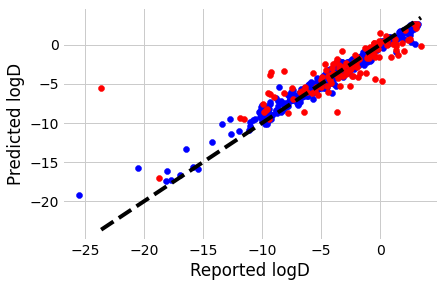

In [99]:
# Plot predicted logD without error bars
plt.scatter(y_train, y_train_pred, color='blue')
plt.scatter(y_test, y_test_pred, color='red')

plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--')
plt.xlabel('Reported logD')
plt.ylabel('Predicted logD')

plt.show()

In [ ]:
# Calculate the variance
V_IJ_unbiased = fci.random_forest_error(rf, X_train, X_test)

In [103]:
print(len(V_IJ_unbiased))
V_IJ_unbiased[:20]

129


array([ 5.00695469,  0.97724178, 13.20131101,  2.37751259,  2.07318971,
        1.20244587,  1.39891014,  2.077658  ,  1.33807251,  1.53163338,
        1.24309879,  1.06931956, 14.16876207,  2.73983864,  2.42319247,
        1.26929535,  1.07953642,  1.190825  ,  3.04033557,  1.18779209])

In [110]:
upper = y_test_pred + 1.96 * np.sqrt(V_IJ_unbiased)
lower = y_test_pred - 1.96 * np.sqrt(V_IJ_unbiased)

In [113]:
CIs_df = pd.DataFrame(
    {'y_test': y_test,
     'y_test_pred': y_test_pred,
     'lower': lower,
     'upper': upper}
)
CIs_df = CIs_df.sort_values(by='y_test')

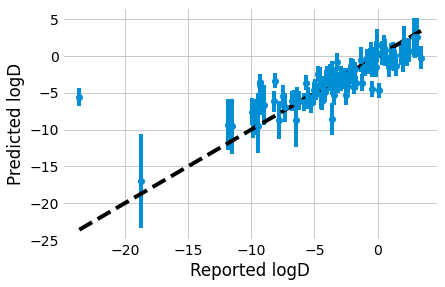

In [102]:
# Plot error bars for predicted pK using unbiased variance
plt.errorbar(x=CIs_df.y_test, y=y_test_pred, yerr=np.sqrt(V_IJ_unbiased), fmt='o')
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--')
plt.xlabel('Reported logD')
plt.ylabel('Predicted logD')
plt.show()

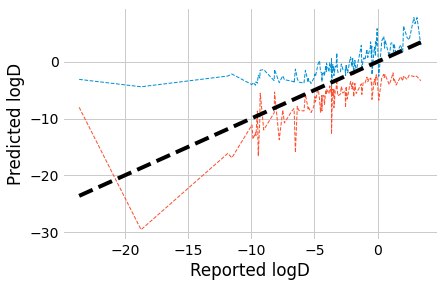

In [119]:
# Plot predicted logD without error bars
#plt.scatter(y_train, y_train_pred, color='blue')
#plt.scatter(y_test, y_test_pred, color='red')
plt.plot(CIs_df.y_test, CIs_df.upper, linewidth=1, linestyle='--')
plt.plot(CIs_df.y_test, CIs_df.lower, linewidth=1, linestyle='--')

plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--')
plt.xlabel('Reported logD')
plt.ylabel('Predicted logD')

plt.show()

In [129]:
within_cis = (CIs_df.lower <= CIs_df.y_test) & (CIs_df.y_test <= CIs_df.upper)
within_cis

(2R,3R,4R,5R)-Hexan-1,2,3,4,5,6-hexol    False
5-iodouracil                              True
1,4-diamino-9,10-anthracenedione          True
2-amino-9,10-anthraquinone                True
acetylsalicylic acid                      True
                                         ...  
3-methylpentane                           True
octane                                    True
3-methylheptane                           True
nonane                                    True
octafluorocyclobutane                    False
Length: 129, dtype: bool

In [130]:
within_cis.sum() / len(within_cis)

0.8682170542635659